In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data getting, cleaning, and exploring
from env import host, user, password
from acquire import get_connection, new_telco_data, get_telco_data
from prepare import clean_telco, impute_mode, train_validate_test_split,impute_mode, prep_telco_data
import explore

# Python without these is hard
import pandas as pd
import numpy as np
from pydataset import data

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import graphviz
from graphviz import Graph

# Data Aquisition 

In [2]:
sql_query = '''
    SELECT *
    FROM customers
    JOIN contract_types USING(`contract_type_id`)
    JOIN internet_service_types USING(`internet_service_type_id`)
    JOIN payment_types USING(payment_type_id);
            '''

In [3]:
get_db_url = f'mysql+pymysql://{user}:{password}@{host}/telco_churn'

In [4]:
df = pd.read_sql(sql_query, get_db_url)

In [5]:
df.isnull().sum()

payment_type_id             0
internet_service_type_id    0
contract_type_id            0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
contract_type               0
internet_service_type       0
payment_type                0
dtype: int64

In [6]:
df.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'paperless_billing', 'monthly_charges',
       'total_charges', 'churn', 'contract_type', 'internet_service_type',
       'payment_type'],
      dtype='object')

In [7]:
df.online_security.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

# Data Preparation

In [8]:
df.replace('No phone service', 'No', inplace=True)
df.replace('No internet service', 'No', inplace=True)
  

In [9]:
dummy_df = pd.get_dummies(df[['gender','contract_type','payment_type']], drop_first=True)
dummy2_df = pd.get_dummies(df[['internet_service_type']], drop_first=False)
dropcols = [
            'gender',
            'payment_type_id',
            'internet_service_type_id',
            'contract_type_id',
            'internet_service_type_none'
               ]

In [10]:
df = pd.concat([df, dummy_df,dummy2_df], axis=1)

In [11]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(','').str.replace(')','')

In [12]:
df.drop(columns=dropcols, inplace=True)

In [13]:
df.columns

Index(['customer_id', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn',
       'contract_type', 'internet_service_type', 'payment_type', 'gender_male',
       'contract_type_one_year', 'contract_type_two_year',
       'payment_type_credit_card_automatic', 'payment_type_electronic_check',
       'payment_type_mailed_check', 'internet_service_type_dsl',
       'internet_service_type_fiber_optic'],
      dtype='object')

In [14]:
df.columns = ['customer_id',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type',
 'gender_male',
 'one_year_contract',
 'two_year_contract',
 'credit_card_payment',
 'e_check_payment',
 'mailed_check_payment',
 'dsl_internet',
 'fiber_optic_internet']

In [15]:
df.total_charges = pd.to_numeric(df.total_charges, errors='coerce').astype('float64')

In [16]:
df.total_charges = df.total_charges.fillna(0)

In [17]:
quant_vars = ['tenure','monthly_charges','total_charges']
cat_vars = list((df.columns).drop(quant_vars))

In [18]:
df1 = df[df.isna().any(axis=1)].drop(columns=cat_vars)

In [19]:
df1.head()

,tenure,monthly_charges,total_charges


In [20]:
df1.total_charges = df1.total_charges.fillna(value=0)

In [21]:
df1.total_charges.isnull().sum()

0

In [22]:
df = df.replace("Yes", 1).replace("No", 0)

In [23]:
df.monthly_charges.describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64

In [24]:
train, validate, test = train_validate_test_split(df)
target = 'churn'

In [25]:
train.shape, validate.shape, test.shape

((3943, 28), (1691, 28), (1409, 28))

# Do customers with more online services churn more than customers with few online services?

In [26]:
train = train[train.internet_service_type != "None"]
validate = validate[validate.internet_service_type != 'None']
test = test[test.internet_service_type != 'None']

In [27]:
train.shape, validate.shape, test.shape

((3105, 28), (1324, 28), (1088, 28))

In [28]:
train = train.drop(columns=['senior_citizen', 'partner', 'dependents', 'tenure', 
                    'phone_service', 'multiple_lines', 'paperless_billing', 
                    'monthly_charges', 'total_charges', 
                    'contract_type', 'payment_type', 'gender_male', 
                    'one_year_contract', 'two_year_contract', 
                    'credit_card_payment', 'e_check_payment', 
                    'mailed_check_payment'])

In [29]:
train.columns

Index(['customer_id', 'online_security', 'online_backup', 'device_protection',
       'tech_support', 'streaming_tv', 'streaming_movies', 'churn',
       'internet_service_type', 'dsl_internet', 'fiber_optic_internet'],
      dtype='object')

In [30]:
train1 = train.melt(id_vars=['customer_id','churn','internet_service_type','dsl_internet','fiber_optic_internet'], var_name='online_services', value_name='nserivces')

In [31]:
train.shape

(3105, 11)

In [41]:
train1 = train1.groupby('customer_id').sum()

In [48]:
train1.churn = train1.churn.replace(6, 1)
train1.dsl_internet = train1.dsl_internet.replace(6, 1)
train1.fiber_optic_internet = train1.fiber_optic_internet.replace(6, 1)
train1.head(), train1.shape

(             churn  dsl_internet  fiber_optic_internet  nserivces
 customer_id                                                      
 0003-MKNFE       0             1                     0          1
 0013-MHZWF       0             1                     0          3
 0013-SMEOE       0             0                     1          6
 0018-NYROU       0             0                     1          0
 0020-JDNXP       0             1                     0          5,
 (3105, 4))

nserivces 
____________________



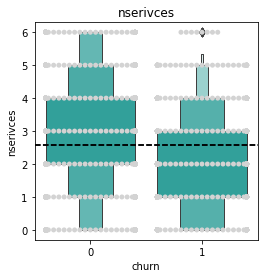

        count      mean       std  min  25%  50%  75%  max
churn                                                     
0      2122.0  2.893968  1.697704  0.0  2.0  3.0  4.0  6.0
1       983.0  1.872838  1.486225  0.0  1.0  2.0  3.0  6.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1397075.0, pvalue=7.392950644947346e-54)

____________________



In [46]:
explore.explore_bivariate_quant(train1, 'churn', 'nserivces')

fiber_optic_internet 
_____________________

         chi2       p-value  degrees of freedom
0  180.089071  4.634177e-41                   1

observed:
 churn                    0    1   All
fiber_optic_internet                 
0                     1106  259  1365
1                     1016  724  1740
All                   2122  983  3105

expected:
              0           1
0   932.859903  432.140097
1  1189.140097  550.859903


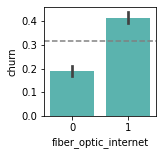


_____________________



In [47]:
explore.explore_bivariate_categorical(train1, 'churn', 'fiber_optic_internet')